In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad

### CSM density for different SNe

In [3]:
# Load CSM data
# In the following we use realistic CSM density from Zimmerman+ Nature 627, 762 (2024)
rho_SN2020tlf_data = np.log10(np.loadtxt('CSM_density/SN2020tlf.txt').T)
rho_SN2023ixf_data = np.log10(np.loadtxt('CSM_density/SN2023ixf.txt').T)
rho_SN2023ixf_sharp_data = np.log10(np.loadtxt('CSM_density/SN2023ixf_sharp.txt').T)
rho_SN2024ggi_data = np.log10(np.loadtxt('CSM_density/SN2024ggi.txt').T)
# Interp in log10 scale
rho_2020tlf_interp = interp1d(rho_SN2020tlf_data[0],rho_SN2020tlf_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2023ixf_interp = interp1d(rho_SN2023ixf_data[0],rho_SN2023ixf_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2023ixf_s_interp = interp1d(rho_SN2023ixf_sharp_data[0],rho_SN2023ixf_sharp_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2024ggi_interp = interp1d(rho_SN2024ggi_data[0],rho_SN2024ggi_data[1],kind='linear',bounds_error=False,fill_value=np.nan)

# Min r for SN
r_mins = {'SN 2020tlf':10**rho_SN2020tlf_data[0,0],
          'SN 2023ixf':10**rho_SN2023ixf_data[0,0],
          'SN 2023ixf s':10**rho_SN2023ixf_sharp_data[0,0],
          'SN 2024ggi':10**rho_SN2024ggi_data[0,0]}
# Max r for SN
r_maxs = {'SN 2020tlf':10**rho_SN2020tlf_data[0,-1],
          'SN 2023ixf':10**rho_SN2023ixf_data[0,-1],
          'SN 2023ixf s':10**rho_SN2023ixf_sharp_data[0,-1],
          'SN 2024ggi':10**rho_SN2024ggi_data[0,-1]} 

def CSM_density(r,SN_name='SN 2023ixf'):
    """
    CSM density for different SN
    
    Parameters
    ----------
    r : scalar
        CSM layer, cm
    SN_name : str
        Name of the SN, only three are documented: SN 2020tlf, SN 2023ixf and SN 2024ggi.

    Returns
    -------
    out : scalr
        CSM density at layer r, g/cm^3
    """
    r = np.log10(r)
    if SN_name == 'SN 2020tlf':
        return 10**rho_2020tlf_interp(r)
    elif SN_name == 'SN 2023ixf':
        return 10**rho_2023ixf_interp(r)
    elif SN_name == 'SN 2023ixf s':
        return 10**rho_2023ixf_s_interp(r)
    elif SN_name == 'SN 2024ggi':
        return 10**rho_2024ggi_interp(r)
    else:
        raise ValueError('\'SN_name\' must be a \'SN 2020tlf\', \'SN 2023ixf\' or \'SN 2024ggi\'.')

SN_names = ['SN 2020tlf','SN 2023ixf','SN 2024ggi']

### Stopping power

In [5]:
# load stopping power data
stop_power_e_H_data = np.loadtxt('stopping_power/electron_H.txt',skiprows=8).T
stop_power_e_He_data = np.loadtxt('stopping_power/electron_He.txt',skiprows=8).T
# interpolate, in log-scale
stop_power_e_H = interp1d(np.log10(stop_power_e_H_data[0]),np.log10(stop_power_e_H_data[-1]),kind='linear',bounds_error=False,fill_value=np.nan)
stop_power_e_He = interp1d(np.log10(stop_power_e_He_data[0]),np.log10(stop_power_e_He_data[-1]),kind='linear',bounds_error=False,fill_value=np.nan)

def stopping_power_electron(Ek):
    """
    Stopping power for electron in different target

    Parameters
    ----------
    Ek : scalar
        Electron kinetic energy, MeV (valid from 0.01 MeV to 1000 MeV)

    Returns
    -------
    out : tup
        Electron stopping power for (H,He), MeV cm^2/g
    """
    logEk = np.log10(Ek)
    sp_H = 10**(stop_power_e_H(logEk))
    sp_He = 10**(stop_power_e_He(logEk))
    return sp_H,sp_He

### Energy loss rate $\Delta E_k/E_k$

In [7]:
def dEdx(r,Ek,X=0.7,Y=0.3,SN_name='SN 2023ixf'):
    """
    Electron energy loss per propagation distance dE/dx at CSM layer

    Parameters
    ----------
    r : scalar
        CSM layer, cm
    Ek : scalar
        Electron kinetic energy, MeV (valid from 0.01 MeV to 1000 MeV)
    X : scalar
        Mass ratio of hydrogen, dimensionless, default 0.7
    Y : scalr
        Mass ratio of helium, dimensionless, default 0.3
    SN_name : str
        Name of the SN, only three are documented: SN 2020tlf, SN 2023ixf and SN 2024ggi.

    Returns
    -------
    out : scalar
        Energy loss, MeV/cm
    """
    # Check whether X+Y=1
    if X + Y != 1.0:
        raise ValueError('X + Y must be 1')
    # Get mixed stopping power
    S_H, S_He = stopping_power_electron(Ek)
    S_mix = X * S_H + Y * S_He
    
    # Get dE/dx
    rho = CSM_density(r,SN_name)
    dE = rho * S_mix
    return - dE

def deposition_efficiency(r0,rmax,Ek,X=0.7,Y=0.3,SN_name='SN 2023ixf'):
    """
    Electron energy deposition efficiency after propagating a distance from r0 to rmax

    Parameters
    ----------
    r0 : scalar
        Initial position in CSM, cm
    rmax : scalar
        End position in CSM, cm
    Ek : scalar
        Electron kinetic energy, MeV (valid from 0.01 MeV to 1000 MeV)
    X : scalar
        Mass ratio of hydrogen, dimensionless, default 0.7
    Y : scalr
        Mass ratio of helium, dimensionless, default 0.3
    SN_name : str
        Name of the SN, only three are documented: SN 2020tlf, SN 2023ixf and SN 2024ggi.

    Returns
    -------
    out : scalar
        Energy deposition efficiency, dimensionless, in (0,1)
    """
    efficiency = quad(lambda r: -dEdx(r,Ek,X,Y,SN_name),r0,rmax)[0] / Ek
    return min(1,efficiency)

In [8]:
r0 = 5e14
rmax = 2e15
CSM_r = np.logspace(np.log10(r0),np.log10(rmax),100)

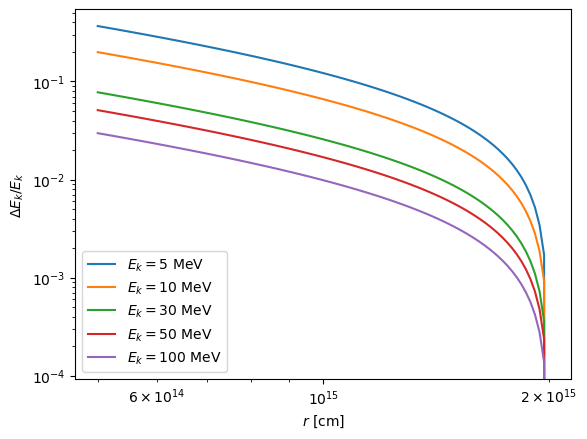

In [9]:
for Ek in [5,10,30,50,100]:
    effy = [deposition_efficiency(r,rmax,Ek) for r in CSM_r]
    plt.plot(CSM_r,effy,label=fr'$E_k={Ek:d}$ MeV')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$\Delta E_k/E_k$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

### Average $\Delta E_k/E_k$ between $(r_0,r_{\rm max})$

To get the average $\Delta E_k/E_k$ over a distance
$$
\overline{\frac{\Delta E_k}{E_k}} = \frac{1}{r_{\rm max}-r_0} \int_{r_0}^{r_{\rm max}} \frac{\Delta E_k}{E_k}(r) dr
$$
I apply Riemann sum for simplicity.

In [11]:
CSM_radii =  np.linspace(r0,rmax,300)
Ek_list = np.logspace(0,2,30)
effy_avg = [np.sum([deposition_efficiency(r,rmax,Ek) for r in CSM_radii])*(CSM_radii[9]-CSM_radii[8])/(rmax-r0) for Ek in Ek_list] 

Text(0.5, 1.0, 'SN 2023ixf with $r\\in[0.5,2]\\times 10^{15}$ cm')

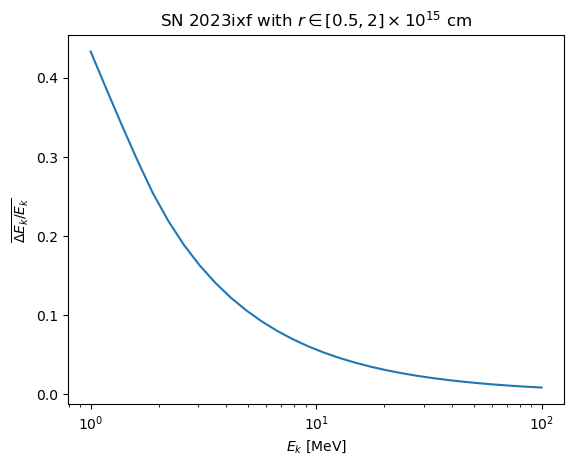

In [12]:
plt.plot(Ek_list,effy_avg)
plt.xscale('log')
plt.xlabel(r'$E_k$ [MeV]')
plt.ylabel(r'$\overline{\Delta E_k/E_k}$')
plt.title(r'SN 2023ixf with $r\in[0.5,2]\times 10^{15}$ cm')